<a href="https://colab.research.google.com/github/younes2808/Sci2XML/blob/main/evaluation/classifier/Code/MLtraining/MLtraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training DenseNet-169 Classifier model

Adapted from: https://www.kaggle.com/code/sunedition/classification-of-graphs

Dataset: https://www.kaggle.com/datasets/sunedition/graphs-dataset?resource=download

>[Training DenseNet-169 Classifier model](#scrollTo=U2bZgFI3K5Zx)

>>[Setup](#scrollTo=a--ctJIfLlIz)

>>[Classification of graphs](#scrollTo=qFiMuecAsPr6)

>>[Seed environment](#scrollTo=9SVTDPOurpGv)

>>[Preparing datasets](#scrollTo=MSBc-2uDrstV)

>>[Exploring the data](#scrollTo=jdTBXv8Vry0u)

>>[Preparing models](#scrollTo=Iaf54QRTr6uS)

>>[Training the models](#scrollTo=nB1xNyWgr_th)

>>[Use the model](#scrollTo=ELU73tTQOgZA)



## Setup

In [ ]:
# Kaggle dataset import code from: https://colab.research.google.com/drive/1DofKEdQYaXmDWBzuResXWWvxhLgDeVyl#scrollTo=0hyJ4Rb5HMwH
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pokerers","key":"ff87911a62ab16b58a34c1fbc575a5a5"}'}

In [ ]:
# Upload text_sentences image folder
from google.colab import files
files.upload()

In [ ]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 64 Feb 24 17:21 kaggle.json


In [ ]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Copy the stackoverflow data set locally.
!kaggle datasets download -d sunedition/graphs-dataset

Dataset URL: https://www.kaggle.com/datasets/sunedition/graphs-dataset
License(s): CC0-1.0
100% 944M/945M [00:47<00:00, 19.3MB/s]
100% 945M/945M [00:47<00:00, 20.8MB/s]


In [ ]:
# Unzip and extract:
!unzip graphs-dataset.zip


In [ ]:
# Unzip additional folder of images.
!unzip text_sentence.zip -d graphs/

In [ ]:
!mv graphs/text_sentence/* graphs/

In [ ]:
!rm -r graphs/text_sentence

In [ ]:
!rm -r graphs/.ipynb_checkpoints

rm: cannot remove 'graphs/.ipynb_checkpoints': No such file or directory


## Classification of graphs
https://www.kaggle.com/code/sunedition/classification-of-graphs

In [ ]:
# install skorch wrapper for pytorch
!pip install -U skorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 15.8 MB/s eta 0:00:00


In [ ]:
# import libraries for file processing
import os

# libraries for image processing
import cv2
import numpy as np
import pandas as pd

# pytorch libraries
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

# skorch wrapper classes and functions
from skorch import NeuralNetClassifier
from skorch.dataset import ValidSplit
from skorch.callbacks import LRScheduler, Checkpoint
from skorch.callbacks import Freezer, EarlyStopping

# albumentations for image augmentation
import albumentations
from albumentations import pytorch

# for multiprocessing
import multiprocessing as mp

# plot graphs for data exploration
import matplotlib.pyplot as plt

## Seed environment

In [ ]:
# Here we seed our environmental variables and pytorch variables
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

    seed_everything(42)

## Preparing datasets

In [ ]:
# Read train dataset from file
#dataset_dir = '/kaggle/input/graphs-dataset/graphs'
dataset_dir = "graphs"
dataset_files = os.listdir(dataset_dir)

print(len(dataset_files))

17687


In [ ]:
# class for dataset loading, labeling and augmentation
class Graphs(Dataset):
    def __init__(self, dir_path, file_list, transform=None):
        self.dir_path = dir_path
        self.file_list = file_list
        self.transform = transform
        self.label_dict = {'just_image' : 0, 'bar_chart' : 1, 'diagram' : 2,
                           'flow_chart' : 3, 'graph' : 4, 'growth_chart' : 5,
                           'pie_chart' : 6, 'table' : 7, 'text_sentence': 8}

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        image_name = os.path.join(self.dir_path, self.file_list[idx])

        if image_name.split('.')[::-1][0] == "gif":
            gif = cv2.VideoCapture(image_name)
            _, image = gif.read()
        else:
            image = cv2.imread(image_name)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        for name, label in self.label_dict.items():
            if name in image_name.split('/')[::-1][0]:
                self.label = label
                break

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, self.label

In [ ]:

dataset_dir = "graphs"
dataset_files = os.listdir(dataset_dir)
print("dataset files: ", dataset_files)
counter = 0
for file in dataset_files:
    counter += 1

    print(file)
    image_name = os.path.join(dataset_dir, file)

    print("image name: ", image_name)
    if image_name.split('.')[::-1][0] == "gif":
            gif = cv2.VideoCapture(image_name)
            _, image = gif.read()
    else:
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print("-->image name: ", image_name)
# .ipynb_checkpoints ellerno feila...


In [ ]:
# declaration of constant variables
batch_size = 128
num_workers = mp.cpu_count()
img_size = 224
n_classes = 9

In [ ]:
# function that prepares dataset for further training
def prepare_datasets(dataset_dir, dataset_files):
    # augmentation parameters for train
    data_transforms = albumentations.Compose([
        albumentations.Resize(img_size, img_size),
        albumentations.HorizontalFlip(),
        albumentations.ShiftScaleRotate(shift_limit=0.3, scale_limit=0.10,
                                        rotate_limit=15),
        albumentations.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        albumentations.pytorch.transforms.ToTensorV2()
    ])

    dataset = Graphs(dataset_dir, dataset_files, transform=data_transforms)

    test_size = int(len(dataset) * 0.3)
    train_set, test_set = random_split(dataset,
                                  (len(dataset_files)-test_size, test_size))

    print(f'Train dataset length: {len(train_set)}')
    print(f'Testset dataset length: {len(test_set)}')

    return train_set, test_set

In [ ]:
# get prepared datasets from files stored in directory
train_set, test_set = prepare_datasets(dataset_dir, dataset_files)

# create dataloaders for loading data in batches=128
trainloader = DataLoader(train_set, batch_size=batch_size,
                         pin_memory=True, num_workers=num_workers, shuffle=True)
testloader = DataLoader(test_set, batch_size=batch_size,
                        pin_memory=True, num_workers=num_workers)

Train dataset length: 12381
Testset dataset length: 5306


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
#from zipfile import ZipFile as zipfiler

# Husk å fjerne .ipynb_checkpoints ellerno feila...

train_images, train_labels = map(list, zip(*[(X.size(), y)
                                             for X, y in iter(train_set)]))
test_images, test_labels = map(list, zip(*[(X.size(), y)
                                             for X, y in iter(test_set)]))

## Exploring the data

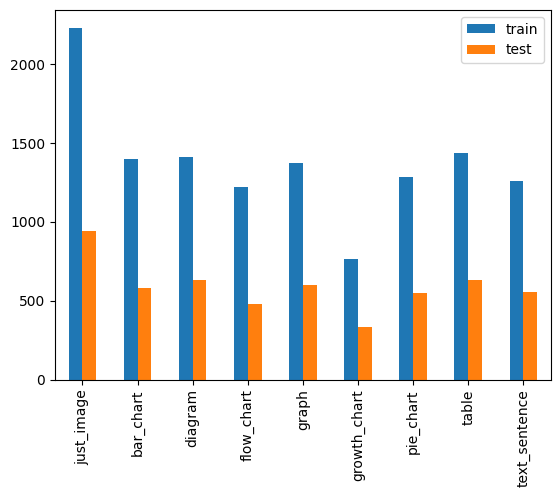

In [ ]:
# plot bar chart to observe amount of images by classes in dataset
class_names = ['just_image', 'bar_chart', 'diagram', 'flow_chart', 'graph',
               'growth_chart', 'pie_chart', 'table', 'text_sentence']

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)

pd.DataFrame({'train': train_counts, 'test': test_counts},
             index=class_names).plot.bar()
plt.show()

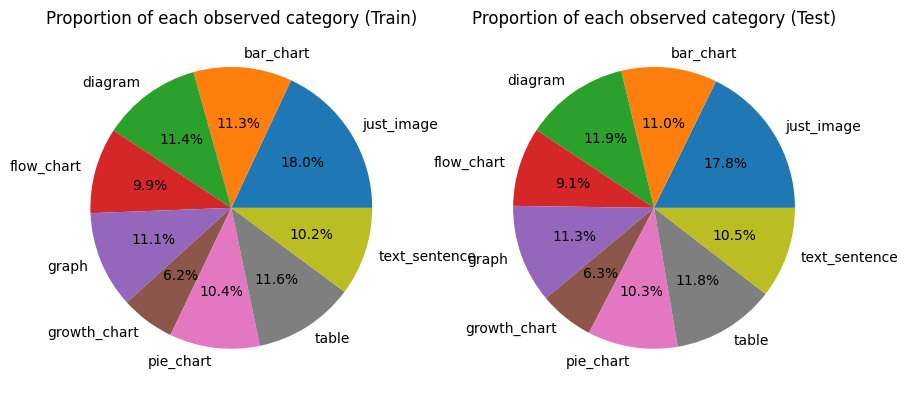

In [ ]:
# plot pie chart to observe proportion of classes in dataset
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.pie(train_counts, explode=(0, 0, 0, 0, 0, 0, 0, 0, 0) ,
        labels=class_names, autopct='%1.1f%%')
ax1.set_title('Proportion of each observed category (Train)')

ax2.pie(test_counts, explode=(0, 0, 0, 0, 0, 0, 0, 0, 0) ,
        labels=class_names, autopct='%1.1f%%')
ax2.set_title('Proportion of each observed category (Test)')

plt.show()

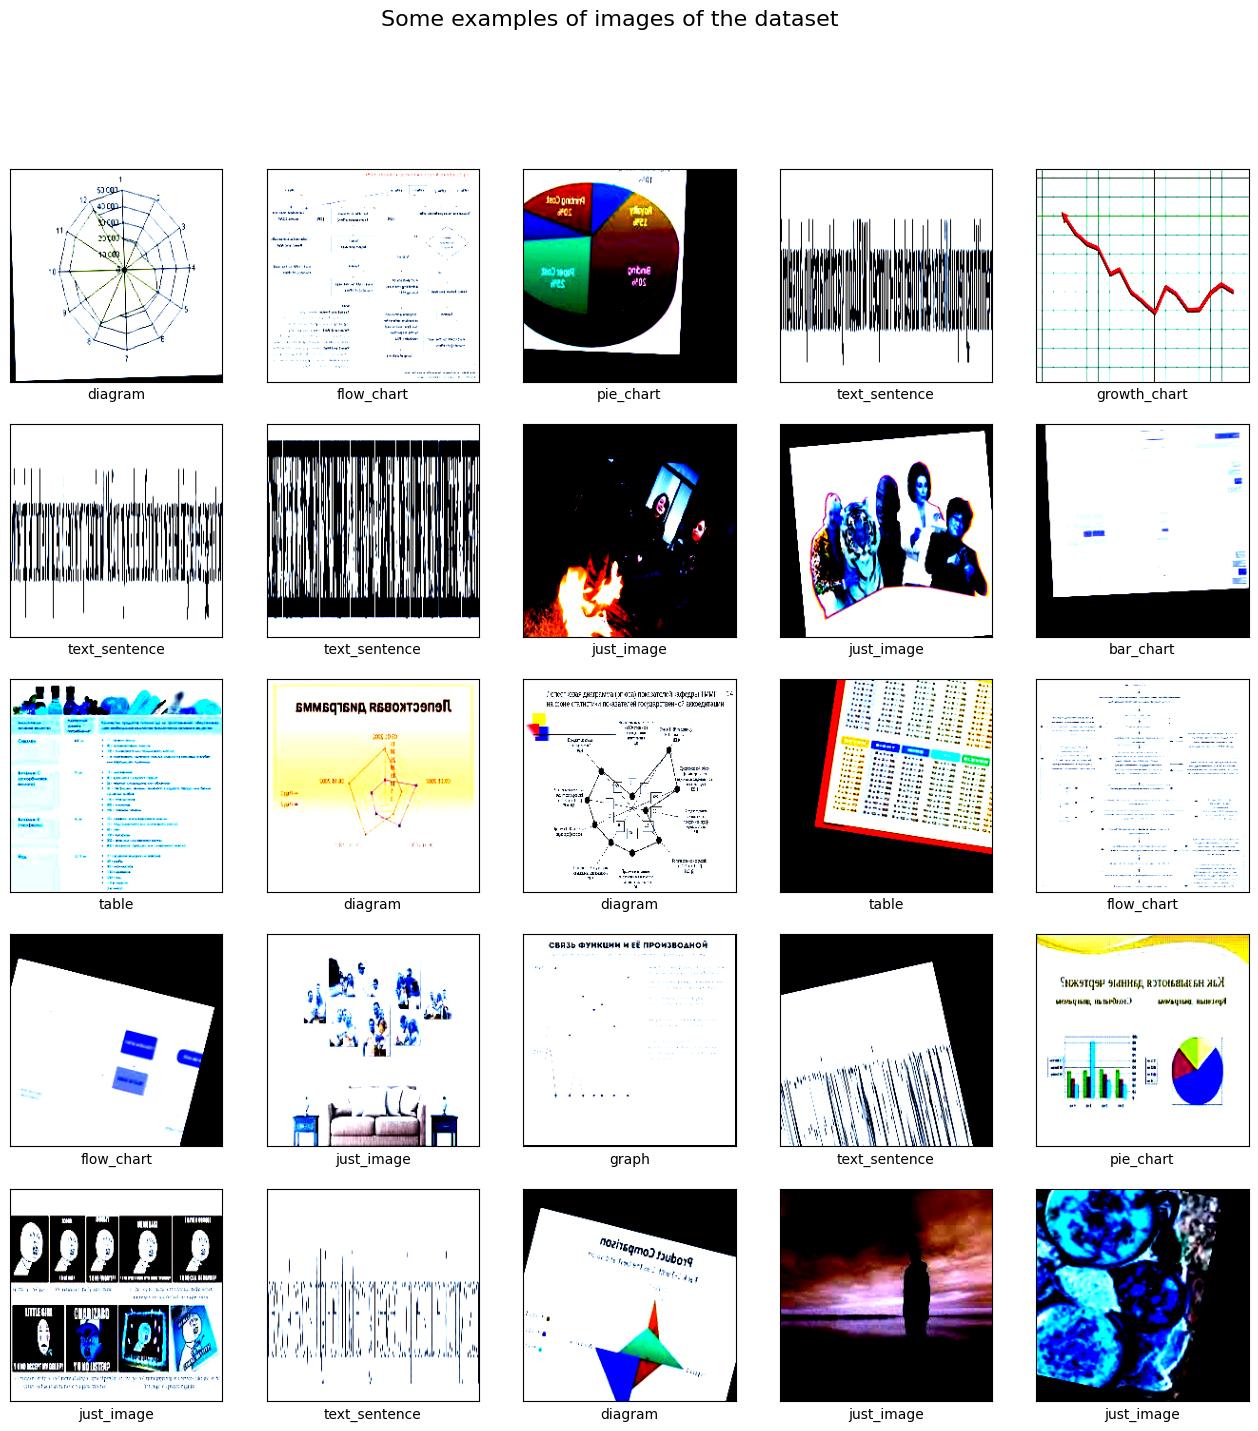

In [ ]:
# print images with labels
train_samples, train_classes = next(iter(trainloader))

fig = plt.figure(figsize=(16, 16))
fig.suptitle("Some examples of images of the dataset", fontsize=16)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.transpose(train_samples[i], (1, 2, 0)), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_classes[i]])
plt.show()

## Preparing models

In [ ]:
# class which uses DenseNet169 pretrained model
# + added custom classifier in the last layer
class DenseNet169(nn.Module):
    def __init__(self, output_features, num_units=512, drop=0.5,
                 num_units1=512, drop1=0.5):
        super().__init__()
        model = torchvision.models.densenet169(pretrained=True)
        n_inputs = model.classifier.in_features
        model.classifier = nn.Sequential(
                                nn.Linear(n_inputs, num_units),
                                nn.ReLU(),
                                nn.Dropout(p=drop),
                                nn.Linear(num_units, num_units1),
                                nn.ReLU(),
                                nn.Dropout(p=drop1),
                                nn.Linear(num_units1, output_features))
        self.model = model

    def forward(self, x):
        return self.model(x)

In [ ]:
# callback functions for models

# DenseNet169
# callback for Reduce on Plateau scheduler
lr_scheduler = LRScheduler(policy='ReduceLROnPlateau',
                                    factor=0.5, patience=1)
# callback for saving the best on validation accuracy model
checkpoint = Checkpoint(f_params='best_model_densenet169_sentence_epoch20.pkl',
                                 monitor='valid_acc_best')
# callback for freezing all layer of the model except the last layer
freezer = Freezer(lambda x: not x.startswith('model.classifier'))
# callback for early stopping
early_stopping = EarlyStopping(patience=5)

In [ ]:
# NeuralNetClassifier for based on DenseNet169 with custom parameters
densenet = NeuralNetClassifier(
    # pretrained DenseNet169 + custom classifier
    module=DenseNet169,
    module__output_features=n_classes,
    # criterion
    criterion=nn.CrossEntropyLoss,
    # batch_size = 128
    batch_size=batch_size,
    # number of epochs to train
    ##### ENDRA FRA 100 TIL 20 #####
    max_epochs=20,
    # optimizer Adam used
    optimizer=torch.optim.Adam,
    optimizer__lr = 0.001,
    optimizer__weight_decay=1e-6,
    # shuffle dataset while loading
    iterator_train__shuffle=True,
    # load in parallel
    iterator_train__num_workers=num_workers,
    # stratified kfold split of loaded dataset
    ##### FJERNA RANDOM_STATE #####
    train_split=ValidSplit(cv=5, stratified=True),
    # callbacks declared earlier
    callbacks=[lr_scheduler, checkpoint, freezer, early_stopping],
    # use GPU or CPU
    device="cuda:0" if torch.cuda.is_available() else "cpu"
)

## Training the models

In [ ]:
# fit prepared model with custom parameters
import time
start = time.time()
densenet.fit(train_set, y=np.array(train_labels))
end = time.time()
print("Training time: ", end-start)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 191MB/s]


  epoch    train_loss    valid_acc    valid_loss    cp      lr      dur
-------  ------------  -----------  ------------  ----  ------  -------
      1        0.7714       0.8958        0.3381     +  0.0010  66.3248
      2        0.3754       0.9197        0.2713     +  0.0010  68.0949
      3        0.3247       0.9080        0.2955        0.0010  65.4698
      4        0.3031       0.9176        0.2810        0.0010  65.6436
      5        0.2925       0.9221        0.2594     +  0.0010  65.0050
      6        0.2802       0.9253        0.2672     +  0.0010  65.3855
      7        0.2743       0.9253        0.2641        0.0010  65.3388
      8        0.2641       0.9221        0.2413        0.0010  67.2457
      9        0.2477       0.9245        0.2623        0.0010  65.0578
     10        0.2351       0.9233        0.2508        0.0010  65.7444
     11        0.2436       0.9261        0.2703     +  0.0010  65.5424
     12        0.2337       0.9265        0.2644     +  0.0010  

In [ ]:
print('Accuracy: {:.5f}%'.format(densenet.score(test_set, test_labels) * 100))

Accuracy: 92.14097%


In [ ]:
pred_classes = np.array([])
for batch_idx, (X_test, y_test) in enumerate(testloader):
    pred_classes = np.append(pred_classes, densenet.predict(X_test).tolist())
print('DenseNet169 prediction done!')

DenseNet169 prediction done!


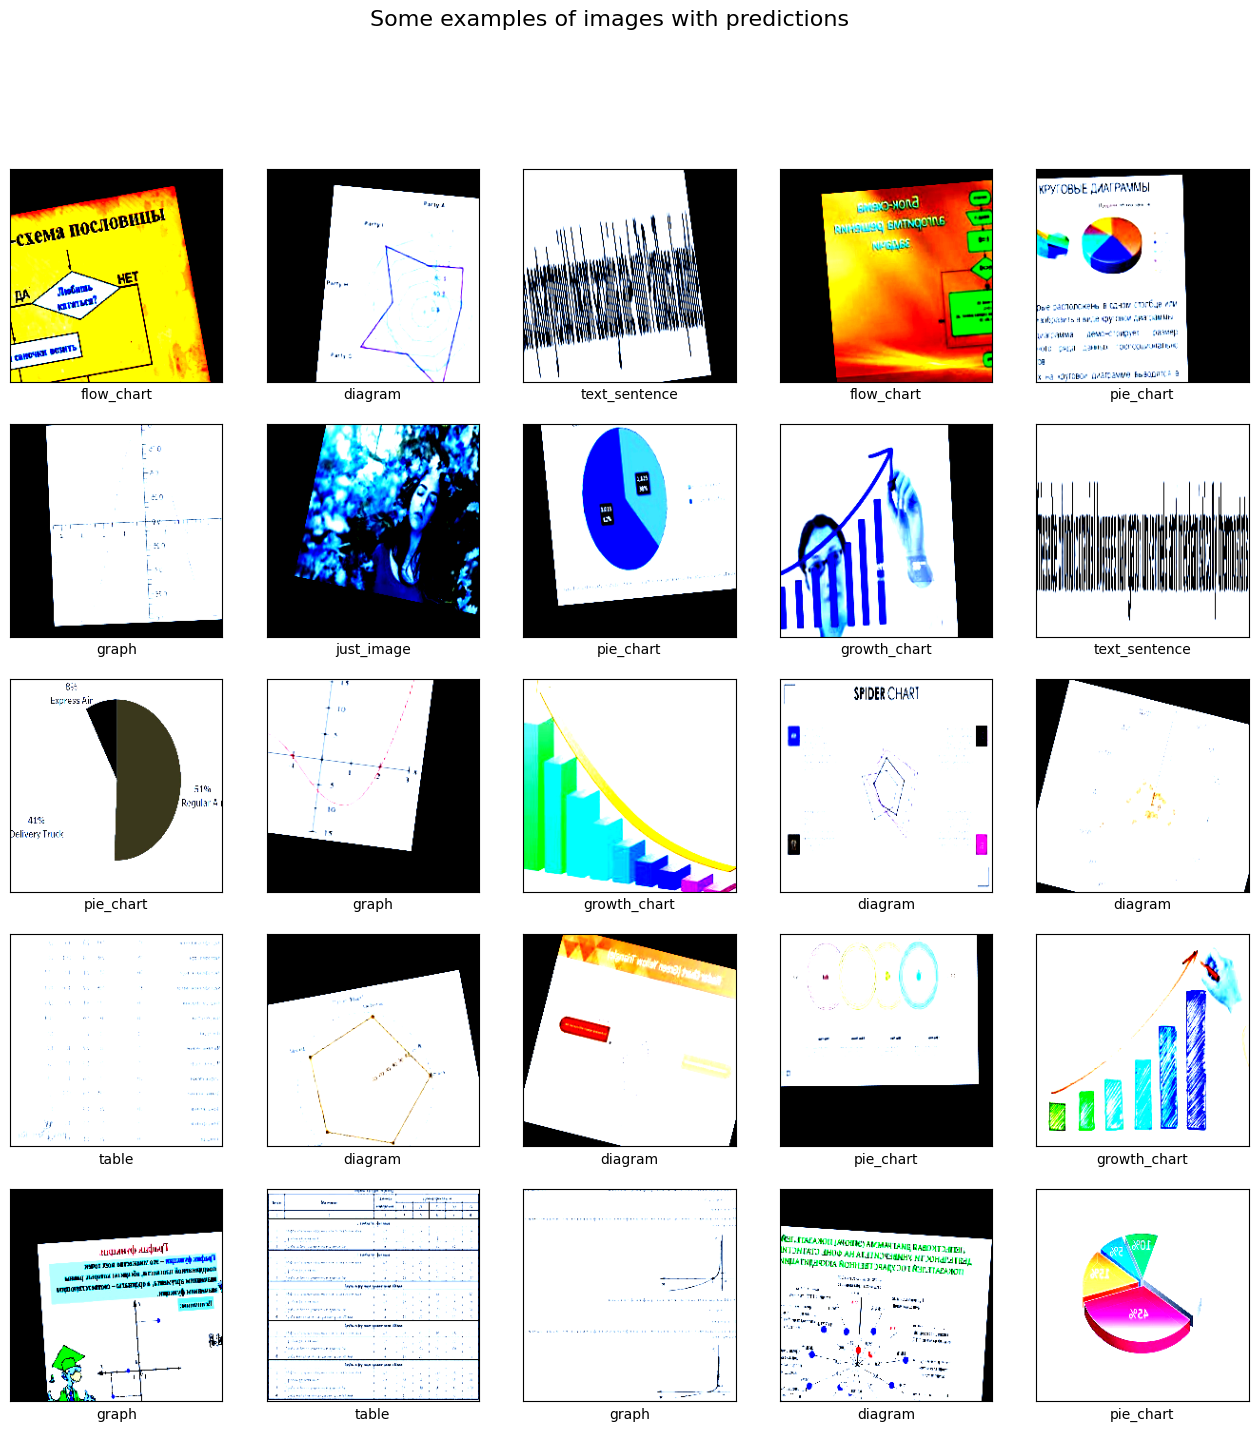

In [ ]:
# print images with labels
test_samples, test_classes = next(iter(testloader))

fig = plt.figure(figsize=(16, 16))
fig.suptitle("Some examples of images with predictions", fontsize=16)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.transpose(test_samples[i], (1, 2, 0)), cmap=plt.cm.binary)
    plt.xlabel(class_names[int(pred_classes[i])])
plt.show()

## Use the model

In [ ]:
from PIL import Image
import albumentations as A
import numpy as np

# Load the image
image_path = "other1.png"  # Replace with the path to your image
image = Image.open(image_path)
image = image.convert("RGB")  # Ensure the image is in RGB format

# Define the same transformations used during training
data_transforms = A.Compose([
    A.Resize(img_size, img_size),
    A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    A.pytorch.transforms.ToTensorV2()
])

# Apply transformations
transformed_image = data_transforms(image=np.array(image))["image"]

# Add a batch dimension
transformed_image = transformed_image.unsqueeze(0)

# Move the image to the appropriate device (GPU or CPU)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
transformed_image = transformed_image.to(device)

# Make prediction
predicted_class = densenet.predict(transformed_image)

# Get the class name
class_names = ['just_image', 'bar_chart', 'diagram', 'flow_chart', 'graph',
               'growth_chart', 'pie_chart', 'table', 'text_sentence']
predicted_class_name = class_names[predicted_class[0]]

print(f"Predicted class: {predicted_class_name}")